## Computational ressources

In [1]:
import dask
import dask.threaded
import dask.multiprocessing
from dask.distributed import Client

c = Client()
c

/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Failed to start diagnostics server on port 8787. [Errno 13] Permission denied
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:35240 Dashboard: http://127.0.0.1:35433/status,Cluster Workers: 8 Cores: 48 Memory: 134.91 GB


## Librairies

In [ ]:
import xarray as xr 
import dask 
import numpy as np 
import os 
import time 
import glob
from datetime import date
today=date.today()

import sys
sys.path.insert(0,'/home/albert7a/git/xscale')
import xscale

import xscale.spectral.fft as xfft
from xscale.spectral.tools import plot_spectrum
import xscale.signal.generator as xgen

import matplotlib.pyplot as plt
params = {'figure.figsize' : (18, 10),'legend.fontsize': 16,'xtick.labelsize':16,'ytick.labelsize':16,'axes.labelsize':16,'font.size':16}
plt.rcParams.update(params)


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/merge.py:16: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  PANDAS_TYPES = (pd.Series, pd.DataFrame, pd.Panel)


## Localisation of the point

In [ ]:
data_dir = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-BLBT02-S/'
tfilename = sorted(glob.glob(data_dir+'*/eNATL60-BLBT02_1h_*_gridT-2D_20090701-20090701.nc'))
filename =tfilename[0]


In [ ]:
%time ds=xr.open_dataset(filename)['sossheig']


In [ ]:
print(ds.nbytes/1e9)

## Importing the data : SSH in run eNATL60-BLBT02 for FMA months at location X

In [ ]:
tfilenames_FMA = []

for month in ['02','03','04']:
    if month in ['12','01','02','03','04','05','06']:
        case='BLBT02X'
    else:
        case='BLBT02'

    if month in ['07','08','09','10','11','12']:
        year='2009'
    else:
        year='2010'
    
    data_dir = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-'+str(case)+'-S/'
    tfilenames_month = sorted(glob.glob(data_dir+'*/eNATL60-'+str(case)+'_1h_*_gridT-2D_'+str(year)+str(month)+'??-'+str(year)+str(month)+'??.nc'))
    tfilenames_FMA=tfilenames_FMA+tfilenames_month

In [ ]:
%time dsFMA=xr.open_mfdataset(tfilenames_FMA)['sossheig'][:,2000,4000]
    

In [9]:
dsFMA

<xarray.DataArray 'sossheig' (time_counter: 2136)>
dask.array<shape=(2136,), dtype=float32, chunksize=(24,)>
Coordinates:
    nav_lat        float32 36.919193
    nav_lon        float32 -31.22679
    time_centered  (time_counter) datetime64[ns] dask.array<shape=(2136,), chunksize=(24,)>
  * time_counter   (time_counter) datetime64[ns] 2010-02-01T00:30:00 ... 2010-04-30T23:30:00
Attributes:
    standard_name:       sea_surface_height_above_geoid
    long_name:           sea surface height
    units:               m
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 h
    cell_methods:        time: mean (interval: 40 s)

In [10]:
print(dsFMA.nbytes/1e9)

8.544e-06


CPU times: user 3.91 s, sys: 775 ms, total: 4.68 s
Wall time: 44.3 s


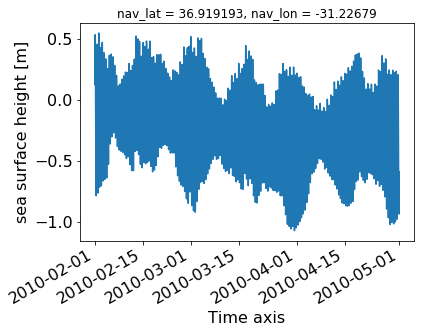

In [11]:
%time dsFMA.plot()

CPU times: user 7.23 s, sys: 521 ms, total: 7.75 s
Wall time: 7.76 s


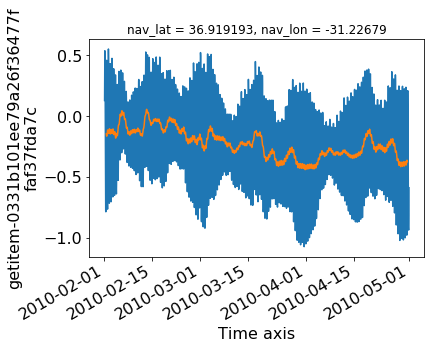

In [12]:
%%time 

dsFMA.plot(label='full data')
dsFMA.rolling(time_counter=24,center=True).mean().plot(label='rolling daily mean')

In [13]:
tfilenames_ASO = []

for month in ['08','09','10']:
    if month in ['12','01','02','03','04','05','06']:
        case='BLBT02X'
    else:
        case='BLBT02'

    if month in ['07','08','09','10','11','12']:
        year='2009'
    else:
        year='2010'
    
    data_dir = '/store/CT1/hmg2840/lbrodeau/eNATL60/eNATL60-'+str(case)+'-S/'
    tfilenames_month = sorted(glob.glob(data_dir+'*/eNATL60-'+str(case)+'_1h_*_gridT-2D_'+str(year)+str(month)+'??-'+str(year)+str(month)+'??.nc'))
    tfilenames_ASO=tfilenames_ASO+tfilenames_month

In [14]:
%time dsASO=xr.open_mfdataset(tfilenames_ASO)['sossheig'][:,2000,4000]
    

CPU times: user 2min 2s, sys: 29.2 s, total: 2min 31s
Wall time: 3min 36s


## FFT decomposition and power spectral density computation

In [15]:
NPADDING = 2
SPtime_FMA = xfft.fft(dsFMA, dim='time_counter', dx=1., detrend='mean',nfft=dsFMA.shape[0]*NPADDING,tapering=True)
MEANPSD_FMA=xfft.psd(SPtime_FMA).load()
freqs_FMA=MEANPSD_FMA.f_time_counter.values
freqs_FMA = freqs_FMA[NPADDING::] 

SPtime_ASO = xfft.fft(dsASO, dim='time_counter', dx=1., detrend='mean',nfft=dsASO.shape[0]*NPADDING,tapering=True)
MEANPSD_ASO=xfft.psd(SPtime_ASO).load()
freqs_ASO=MEANPSD_ASO.f_time_counter.values
freqs_ASO = freqs_ASO[NPADDING::] 


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/xarray/core/dataarray.py:218: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  elif isinstance(data, pd.Panel):


Text(0.5, 1.0, 'Temporal Spectrum of SSH at the point')

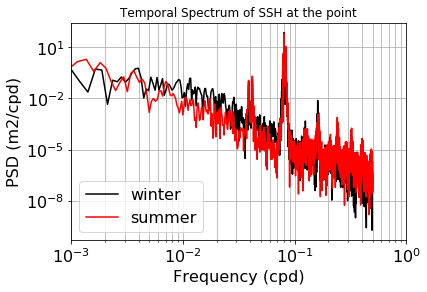

In [16]:
fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)

ax.loglog(freqs_FMA,MEANPSD_FMA[NPADDING::],'k',label='winter')
ax.loglog(freqs_ASO,MEANPSD_ASO[NPADDING::],'r',label='summer')
ax.set_xlim(1e-3,1)
ax.grid(which='both',axis='both')
plt.xlabel('Frequency (cpd)')
plt.ylabel('PSD (m2/cpd)')
plt.legend()
plt.title('Temporal Spectrum of SSH at the point')